# Display top 10 agents with most alerts from the last 24 hours

This notebook uses a Python environment to demonstrate how a NetBeez user can retrive data from the API and manipulate them and visualize them in a meaningful way.

First we describe the setup process for getting data from the API.

## Setup your NetBeez Beezkeeper details

First you need to identify your server's FQDN and generate an API key to use in these examples.

If the URL you use to access NetBeez looks like this https://demo.netbeecloud.net then `demo.netbeecloud.net` is the fqdn.

### Setup your instance FQDN

In [1]:
beezkeeper_fqdn="demo.netbeezcloud.net"  ## <--------- CHANGE THIS TO YOUR INSTANCE FQDN
base_url='https://' + beezkeeper_fqdn

### Add your API Key

In [2]:
from IPython.display import Markdown as md

md(f"To generate an API key head over to https://{beezkeeper_fqdn}/#settings-tab/api-keys-settings")

To generate an API key head over to https://demo.netbeezcloud.net/#settings-tab/api-keys-settings

In [3]:
api_key="7g5_hKXw_460SNKEkJEYlMn1eqw3iTmaus_cCMZ8REhc5MOEtEAx8g"  # <--------- CHANGE THIS TO YOUR KEY

## Setup the headers
We define the content type format as JSON and provide the API key that you generated in the previous step as part of the headers.

In [4]:
import requests
import urllib3

urllib3.disable_warnings()


headers = {
            'Cache-Control': 'no-store',
            'Content-type': 'application/json',
            'Authorization': 'Bearer ' + api_key
          }

legacy_api_headers = {
    'Authorization': api_key,
    'API-VERSION': 'v1',
    'Content-type': 'application/json'
}

Note that when the legacy api headers are used it means that we are using the legacy API which is subject to be replaced soon by the new JSON API (documentation here: https://api.netbeez.net)

## Example: Get the top 10 Agents with the most alerts triggered during the past 24 hours.

In this example we will be retrieve all the alerts triggered during the past 24 hours. Then we'll group them by agent and count them on a per agent basis. We then sort and pick the top 10. We then enrich the data with the agent names by fetching them through some extra API calls.

### Timestamps
First we set the timestamps for `from` and `to`

In [5]:
import time
import datetime
to_ts = int(time.time() * 1000 - 3 * 24 * 60 * 60 * 1000)
from_ts = to_ts - (24 * 60 * 60 * 1000)

print(f"From: {datetime.datetime.fromtimestamp(from_ts/1000.0)}")
print(f"To:   {datetime.datetime.fromtimestamp(to_ts/1000.0)}")

From: 2021-12-10 04:48:34.612000
To:   2021-12-11 04:48:34.612000


We then retrieve the alerts using the `/nb_alerts.json` legacy api from swagger.

In [6]:
import pandas as pd

url = f"{base_url}/nb_alerts.json?from={from_ts}&to={to_ts}"
response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
print(response)
df = pd.json_normalize(response.json(), 'current_alerts')


<Response [200]>


Then we filter out only the alerts with severity less than 5 (faillure alerts have severity 1, and warning alerts have severity 4. When an alert is cleared that event is marked with severity 6). Then count the alerts per agent, and then get the top 10.

In [7]:
opening_alerts = df[df['severity'] < 5]
count_per_agent = opening_alerts[['source_agent_id', 'severity']].groupby(['source_agent_id']).count()
count_per_agent = count_per_agent.rename(columns={'severity':'count'})
count_per_agent.index = pd.to_numeric(count_per_agent.index, downcast='integer')
top_10 = count_per_agent.nlargest(10, columns='count')
print(top_10)

                 count
source_agent_id       
54                 226
279                106
388                 92
341                 89
280                 78
335                 78
249                 77
297                 77
329                 76
319                 75


### Plot the alerts

To convert the agent ids to agent names we then retrieve the agent objects one by one and extract the name strings from those objects.

In [8]:
agent_names = []
for agent_id in top_10.index:
    url = f"{base_url}/agents/{agent_id}.json"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    agent_names.append(response.json()['name'])
    
print("Done loading names")

Done loading names


Finally, we prepare the data for plotting.

In [9]:
to_plot = pd.DataFrame(index=agent_names, data=top_10.values, columns=['Alert Count'])
to_plot.index.rename('Agents')
print(to_plot)

                            Alert Count
Cloud - Google                      226
Pittsburgh - Wired 2                106
San Jose - Wired                     92
Pittsburgh - Virtual Agent           89
Pittsburgh - Wired                   78
Steven's - Unraid                    78
San Jose - WiFi                      77
Pittsburgh - WiFi Main               77
DESKTOP-S87JLNG                      76
Pittsburgh - SmartSFP                75


<AxesSubplot:>

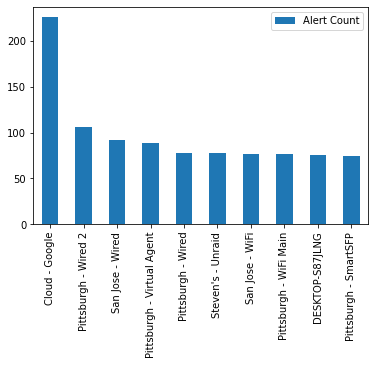

In [10]:
to_plot.plot.bar()